In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-nano")
result = llm.invoke("what is the capital of india")
print(result.content)

The capital of India is New Delhi.


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini")

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/e5-base-v2",
    encode_kwargs={'normalize_embeddings': True}  # important for E5 models
)

In [5]:
from langchain_community.document_loaders import WebBaseLoader


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/"
]

In [7]:
docs = [WebBaseLoader(url).load() for url in urls]
docs = [sublist for list in docs for sublist in list]

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)
split_docs = text_splitter.split_documents(docs)

In [9]:
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(
    documents=split_docs,
    collection_name="bhai",
    embedding=embeddings
)

In [10]:
retriever = vectorstore.as_retriever()

In [11]:
retriever.invoke("what is agent and prompt?")

[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'language': 'en', 'title': "Prompt Engineering | Lil'Log"}, page_content='Prompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore we can treat them as trainable parameters and optimize t

In [12]:
from typing import TypedDict, Sequence, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [16]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_blogger",
    "description"
)
tools = [retriever_tool]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langchain_core.prompts import PromptTemplate
def llm_decision_maker(state: AgentState):
    last_message = state["messages"][-1].content
    prompt=PromptTemplate(
        template="""
            You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
            Here is the question:{question}
            """,
            input_variables=["question"]
    )
    chain = prompt | llm_with_tools
    response = chain.invoke({"question":last_message})
    return {"messsages": [response]}

In [ ]:
 n
def query_rewriter(state: AgentState): return {"messsages": []}

In [40]:
def generator(state: AgentState): return {"messsages": []}

In [67]:

from langgraph.graph import StateGraph, END, START
workflow = StateGraph(AgentState)

In [ ]:
workflow.add_node("LLM_Decision Maker", llm_decision_maker)
workflow.add_node("Vector Retriever", retriever_tool)
workflow.add_node("Generator", generator)
workflow.add_node("Query Rewriter", query_rewriter)

In [69]:
workflow.add_edge(START, "LLM_Decision Maker")

In [70]:
workflow.add_conditional_edges("LLM_Decision Maker",
                                lambda tools_condition : "",
                                {
                                    "tool": "Vector Retriever",
                                    END: END
                                }
)

In [71]:
workflow.add_edge("Query Rewriter", "LLM_Decision Maker")

In [72]:
workflow.add_conditional_edges("Vector Retriever",
                               lambda grader: "",
                               {
                                   "yes": "Generator",
                                   "no" : "Query Rewriter"
                               }
)

In [73]:
workflow.add_edge("Generator", END)

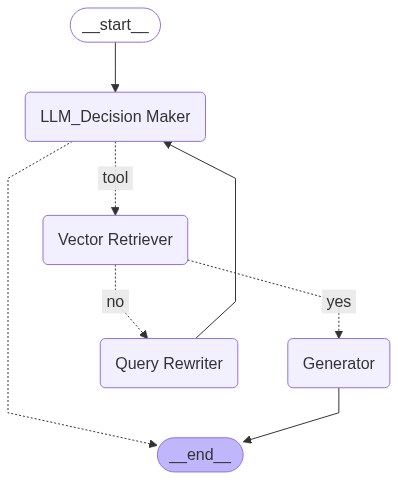

In [74]:
graph = workflow.compile()
graph